In [1]:
import spotipy, pandas as pd, json, numpy as np
from spotipy.oauth2 import SpotifyOAuth
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, permutations
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
scope = 'playlist-modify-public playlist-modify-private'
red_url = 'http://localhost:8080'
#playlist = 'https://open.spotify.com/playlist/37i9dQZEVXcD0rEV1cHpue?si=cba0a3fd1e1a47b4' #Discover Weekly
playlist = 'https://open.spotify.com/playlist/0zZlkqz8ZRPsZd0kARwia9?si=2b1315ae6d884cb5' # big test playlist

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(redirect_uri=red_url,scope=scope))

In [3]:
offset = 0
song_ids = []
while True:
    songs = sp.playlist_tracks(playlist_id=playlist, offset=offset, fields='items.track.id', limit=100)['items']
    if len(songs) == 0:
        break
    song_ids += [d['track']['id'] for d in songs]
    offset = offset + len(songs)

In [4]:
offset = 0
limit = 50
song_feats = []
while offset < len(song_ids):
    song_feats += sp.audio_features(tracks=song_ids[offset: offset + limit])
    offset += limit

In [5]:
# aud_anal = []
# aud_secs = []
# j = 0
# for song in song_ids:
#     track = sp.audio_analysis(song_ids[j])
#     dur = track['track']['duration']
#     secs = len(track['sections'])
#     aud_anal.append(track)
#     aud_secs.append(60*secs/dur)
#     j += 1

In [6]:
df_feats = pd.DataFrame(song_feats).drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'key', 'time_signature'], axis=1)
# df_aud = pd.DataFrame(aud_anal)[['tempo_confidence','time_signature_confidence','key_confidence','mode_confidence']]
# df_secs = pd.DataFrame({'secs/min': aud_secs})

In [7]:
#df_dummies = pd.get_dummies(df_feats[['key', 'time_signature']], columns=['key', 'time_signature'], drop_first=True)

In [8]:
to_norm = df_feats[['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']].values
scaler = pre.MinMaxScaler()
normed = scaler.fit_transform(to_norm)
df_normed = pd.DataFrame(normed).rename(columns={0: 'loudness', 1: 'tempo', 2: 'speechiness', 3: 'acousticness', 4: 'instrumentalness', 5: 'liveness'})

In [9]:
df_feats.drop(['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness'], axis=1, inplace=True)

In [10]:
df_feats = df_feats.join(df_normed).set_index('id')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


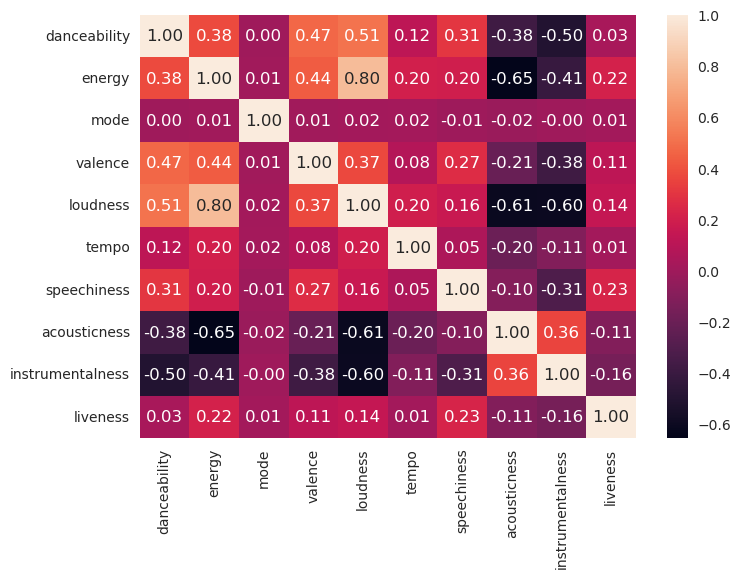

In [11]:
sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

In [12]:
# df_feats.drop(['loudness', 'acousticness'], axis=1, inplace=True)

In [13]:
# df_feats.head()

In [14]:
# sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

In [15]:
n_clusters = [2, 3, 4, 5, 6]
cluster_scores = []
for n in n_clusters:
    clusters = KMeans(n_clusters=n)
    labs = clusters.fit_predict(df_feats.values)
    sil_avg = silhouette_score(df_feats.values, labs)
    cluster_scores.append(sil_avg)

In [16]:
cluster_scores

[0.37037997466283346,
 0.39319883432539715,
 0.3843656872649276,
 0.354172401047249,
 0.31648963108603384]

In [17]:
clustered = KMeans(n_clusters=cluster_scores.index(max(cluster_scores))+min(n_clusters))

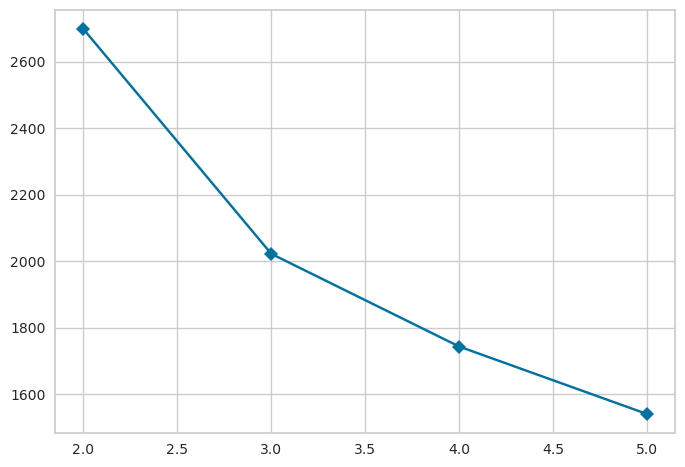

In [18]:
visualizer = KElbowVisualizer(KMeans(), k=(min(n_clusters),max(n_clusters)), timings=False)
visualizer.fit(df_feats.values)
score = visualizer.elbow_score_
value = visualizer.elbow_value_

In [19]:
type(value)

NoneType

In [20]:
cols = list(df_feats)

In [21]:
cols

['danceability',
 'energy',
 'mode',
 'valence',
 'loudness',
 'tempo',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness']

In [22]:
combos = list(combinations(cols, 3))

In [23]:
sub = df_feats[list(combos[0])]

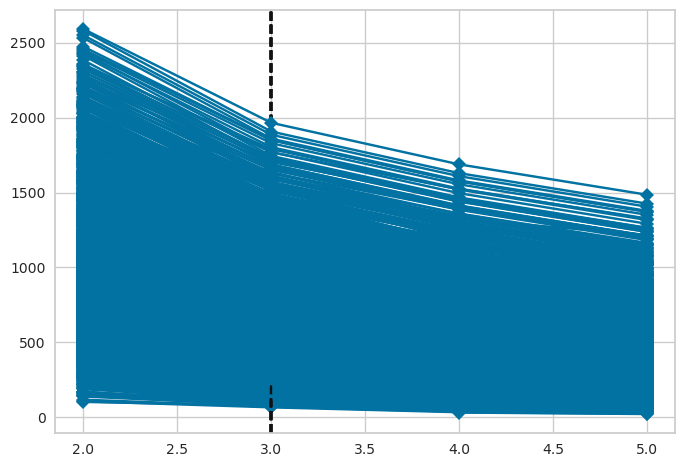

In [24]:
# feats = 2
# outputs = {}
# while feats < len(cols):
#     combos = list(combinations(cols, feats))
#     outputs[f'{feats}_feat_combos'] = combos
#     elb_scores = []
#     elb_values = []
#     for combo in combos:
#         subset = df_feats[list(combo)]
#         model = KElbowVisualizer(KMeans(), k=(min(n_clusters), max(n_clusters)), timings=False)
#         model.fit(subset.values)
#         elb_scores.append(model.elbow_score_)
#         elb_values.append(visualizer.elbow_value_)
#         outputs[f'{feats}_feat_elb_scores'] = elb_scores
#         outputs[f'{feats}_feat_elb_values'] = elb_values
#     feats += 1

In [ ]:
n_clusters = [2, 3, 4, 5, 6]
cluster_scores = []
for n in n_clusters:
    clusters = KMeans(n_clusters=n)
    labs = clusters.fit_predict(df_feats.values)
    sil_avg = silhouette_score(df_feats.values, labs)
    cluster_scores.append(sil_avg)

In [ ]:
feats = 2
outputs = {}
while feats < len(cols):
    combos = list(combinations(cols, feats))
    outputs[f'{feats}_feat_combos'] = combos
    sil_scores = []
    for combo in combos:
        subset = df_feats[list(combo)]
        cluster_scores = []
        for n in n_clusters:
            clusters = KMeans(n_clusters=n)
            labs = clusters.fit_predict(df_feats.values)
            sil_avg = silhouette_score(df_feats.values, labs)
            cluster_scores.append(sil_avg)
        outputs[f'{feats}_feat_sil_scores'] = cluster_scores
    feats += 1

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 
